In [1]:
library('pROC')

Warning message:
"package 'pROC' was built under R version 3.4.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [2]:
point_distance = function(x,y)
    {   return(sqrt((1-x)^2 + (1-y)^2)) }

In [3]:
gameplay_df = read.csv(file = 'gameplay_data_metrics.csv',header = T)

In [4]:
log_energy = log(gameplay_df$energy,2)
avg_amp = scale(gameplay_df$avg_amp)
max_amp = scale(gameplay_df$max_amp)
energy = scale(gameplay_df$energy)
sids = as.numeric(gameplay_df$sampID)

In [5]:
temp = cbind(avg_amp,energy,max_amp,log_energy)
colnames(temp) = c('avg_amp', 'energy', 'max_amp', 'log_energy')
cor(temp)

,avg_amp,energy,max_amp,log_energy
avg_amp,1.0000000,0.9938466,0.4866060,0.8442596
energy,0.9938466,1.0000000,0.5001845,0.8542637
max_amp,0.4866060,0.5001845,1.0000000,0.4629704
log_energy,0.8442596,0.8542637,0.4629704,1.0000000


# Gameplay Level Model

### Linear model

In [14]:
y_linear = as.numeric(gameplay_df$tremor) - 1
model_linear = lm(y_linear ~ avg_amp + max_amp + log_energy)
summary(model_linear)



Call:
lm(formula = y_linear ~ avg_amp + max_amp + log_energy)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7401 -0.5317  0.2920  0.4341  1.3333 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.94263    0.67362   2.884   0.0041 ** 
avg_amp      0.18765    0.04048   4.636 4.53e-06 ***
max_amp     -0.13629    0.02448  -5.568 4.17e-08 ***
log_energy  -0.08680    0.04167  -2.083   0.0377 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4799 on 507 degrees of freedom
Multiple R-squared:  0.0802,	Adjusted R-squared:  0.07476 
F-statistic: 14.74 on 3 and 507 DF,  p-value: 3.259e-09


In [15]:
ROC_linear = roc(response = y_linear, predictor = predict(model_linear))
ROC_linear$auc

Area under the curve: 0.696

# Patient Level Models

## Median Model

In [7]:
patient_disease_status = read.table(file = './data/sample_disease_info.txt', header=T, fill =T, sep = '\t', row.names = 1)
valid_rows = which(row.names(patient_disease_status) %in% gameplay_df$sampID)
patient_disease_status = patient_disease_status[valid_rows,]
head(patient_disease_status)

,disease,pd_history,notes
sc002b,PD,N,
sc007g,PD,N,
sc009i,PD,N,
sc010j,PD,N,
sc011k,PD,N,
sc013m,PD,N,


In [8]:
prediction_results = predict(model_linear)
patient_ids = row.names(patient_disease_status)
actual_disease = patient_disease_status$disease

mean_prediction = c()
median_prediction = c()

for (id in patient_ids)
    {
        pat_ind = which(gameplay_df$sampID == id)
        mean_predicted_score = mean(prediction_results[pat_ind])
        median_predicted_score = median(prediction_results[pat_ind])
        mean_prediction = c(mean_prediction,mean_predicted_score)
        median_prediction = c(median_prediction,median_predicted_score)
    }

In [9]:
y_agg = as.numeric(actual_disease) - 1

In [10]:
model_median = lm(y_agg ~ median_prediction)
res_median = fitted(model_median)
summary(model_median)


Call:
lm(formula = y_agg ~ median_prediction)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8078 -0.4265  0.1299  0.4211  0.5757 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)        -1.1298     0.5251  -2.152  0.03709 * 
median_prediction   3.0200     0.9330   3.237  0.00233 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4558 on 43 degrees of freedom
Multiple R-squared:  0.1959,	Adjusted R-squared:  0.1772 
F-statistic: 10.48 on 1 and 43 DF,  p-value: 0.00233


[1] 0.76

[1] 0.65

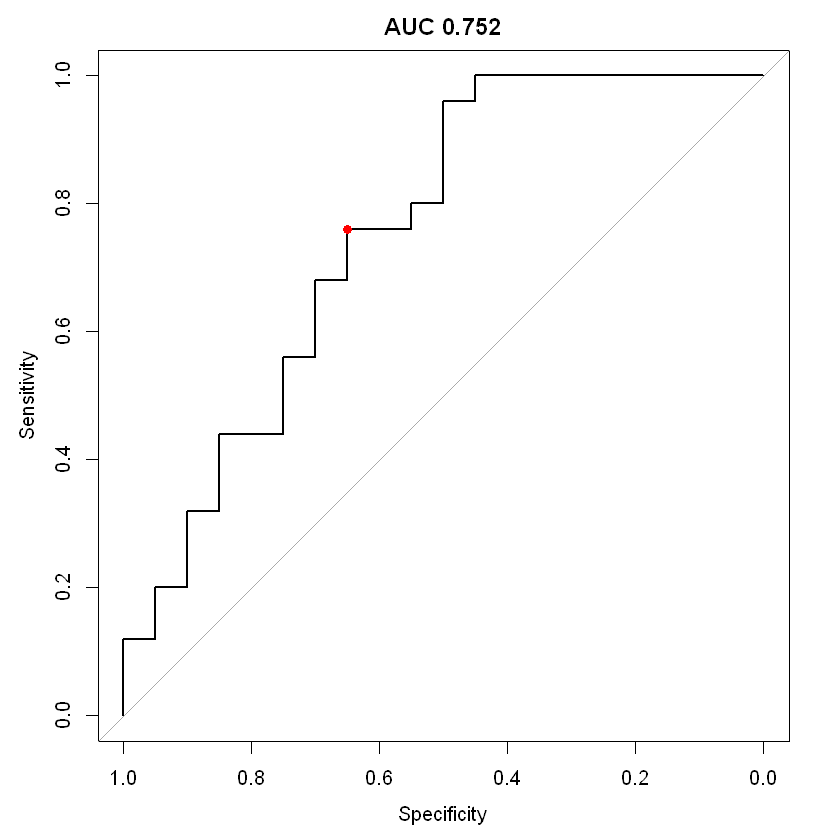

In [11]:
ROC_median = roc(response = y_agg, predictor = res_median)
plot.roc(ROC_median, main = paste('AUC',round(ROC_median$auc,4)))

distances = point_distance(ROC_median$sensitivities, ROC_median$specificities)
best_point = which(distances == min(distances))
points(y = ROC_median$sensitivities[best_point], x = ROC_median$specificities[best_point], col = 'red',pch=19)

ROC_median$sensitivities[best_point]
ROC_median$specificities[best_point]

## Median + GRS Model

In [15]:
patient_pd_grs = read.table(file = './data/genetic_data/snp_grs.txt',col.names = c('user_num','grs'))
head(patient_pd_grs)

user_num,grs
1,2.080211
2,2.551895
3,2.061779
4,2.089163
5,1.588184
6,1.996205


In [16]:
patient_ids_mapping = sapply( (strsplit(x = row.names(patient_disease_status),split = "[[:lower:]]")), `[`, 3)
patient_ids_mapping = as.data.frame(cbind(row.names(patient_disease_status),as.numeric(patient_ids_mapping)))
colnames(patient_ids_mapping) = c('patient_id','patient_num')
head(patient_ids_mapping)

patient_id,patient_num
sc002b,2
sc007g,7
sc009i,9
sc010j,10
sc011k,11
sc013m,13


In [17]:
grs_index = match(patient_ids_mapping$patient_num, patient_pd_grs$user_num)
patient_grs = patient_pd_grs$grs[grs_index]

In [18]:
model_agg = lm(y_agg ~ median_prediction + patient_grs)
res_agg = fitted(model_agg)
summary(model_agg)


Call:
lm(formula = y_agg ~ median_prediction + patient_grs)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8162 -0.4194  0.1283  0.4179  0.5702 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)       -0.97597    0.68259  -1.430  0.16017   
median_prediction  2.98987    0.94639   3.159  0.00293 **
patient_grs       -0.06778    0.18923  -0.358  0.72199   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4605 on 42 degrees of freedom
Multiple R-squared:  0.1984,	Adjusted R-squared:  0.1602 
F-statistic: 5.196 on 2 and 42 DF,  p-value: 0.009628


[1] 0.8

[1] 0.65

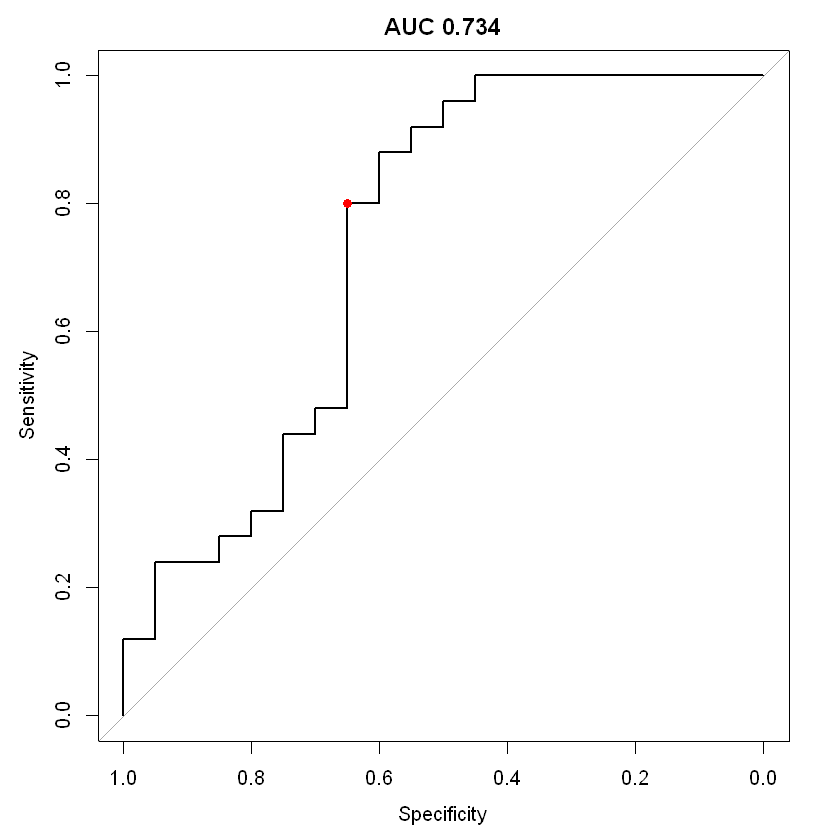

In [19]:
ROC_agg = roc(response = y_agg, predictor = res_agg)
plot.roc(ROC_agg, main = paste('AUC',round(ROC_agg$auc,4)))

distances = point_distance(ROC_agg$sensitivities, ROC_agg$specificities)
best_point = which(distances == min(distances))
points(y = ROC_agg$sensitivities[best_point], x = ROC_agg$specificities[best_point], col = 'red',pch=19)

ROC_agg$sensitivities[best_point]
ROC_agg$specificities[best_point]

### Model with GRS plus Patient PD history

In [20]:
family_history = as.numeric(patient_disease_status$pd_history) - 1
agg_model = lm(y_agg ~ (median_prediction + patient_grs + family_history))
res = fitted(agg_model)
summary(agg_model)


Call:
lm(formula = y_agg ~ (median_prediction + patient_grs + family_history))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8026 -0.3764  0.1312  0.4242  0.6179 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)        -1.2756     0.7466  -1.708  0.09511 . 
median_prediction   3.2962     0.9957   3.310  0.00195 **
patient_grs        -0.0197     0.1954  -0.101  0.92019   
family_history      0.2022     0.2039   0.991  0.32728   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4606 on 41 degrees of freedom
Multiple R-squared:  0.2171,	Adjusted R-squared:  0.1598 
F-statistic:  3.79 on 3 and 41 DF,  p-value: 0.01729


[1] 0.76

[1] 0.7

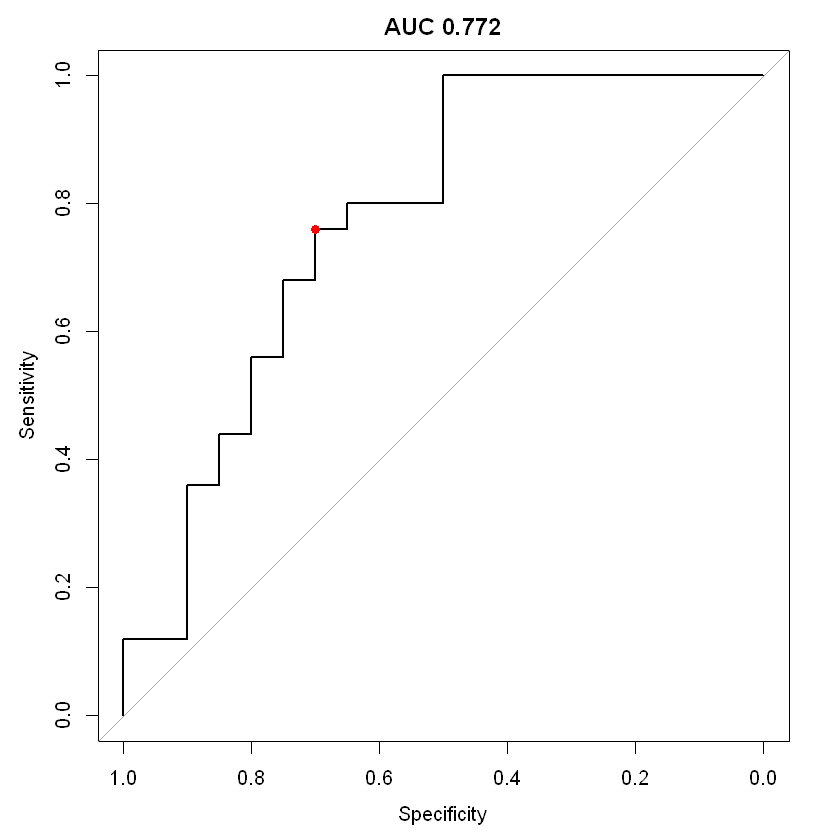

In [21]:
ROC = roc(response = y_agg, predictor = res)
plot.roc(ROC, main = paste('AUC',round(ROC$auc,4)))

distances = point_distance(ROC$sensitivities, ROC$specificities)
best_point = which(distances == min(distances))
points(y = ROC$sensitivities[best_point], x = ROC$specificities[best_point], col = 'red',pch=19)

ROC$sensitivities[best_point]
ROC$specificities[best_point]

## VOTING

In [22]:
mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

SEN = c()
SPE = c()
ACC = c()

for (prob in seq(0,1,0.001))
     {
        results = prediction_results
        results[which(results<prob)] = 'ET'
        results[which(results != 'ET')] = 'PD'
      
        predicted_disease = c()
        for (id in patient_ids)
            {
                pat_ind = which(gameplay_df$sampID == id)
                pat_res = results[pat_ind]
                predicted_disease = c(predicted_disease,mode(pat_res))
            }

        pd_ind = which(actual_disease == 'PD')
        et_ind = which(actual_disease == 'ET')

        tp = length(which(predicted_disease[pd_ind] == 'PD'))
        tn = length(which(predicted_disease[et_ind] == 'ET'))
        fn = length(which(predicted_disease[pd_ind] != 'PD'))
        fp = length(which(predicted_disease[et_ind] != 'ET'))

        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        accuracy = (tp+tn)/(tp+tn+fp+fn)

        SEN = c(SEN,sensitivity)
        SPE = c(SPE,specificity)
        ACC = c(ACC, accuracy)
    }


[1] "Max Accuracy = 0.756"

[1] "Max Sensitivity = 0.96" "Max Sensitivity = 0.96" "Max Sensitivity = 0.96"
 [4] "Max Sensitivity = 0.96" "Max Sensitivity = 0.96" "Max Sensitivity = 0.96"
 [7] "Max Sensitivity = 0.96" "Max Sensitivity = 0.96" "Max Sensitivity = 0.96"
[10] "Max Sensitivity = 0.96" "Max Sensitivity = 0.96" "Max Sensitivity = 0.96"
[13] "Max Sensitivity = 0.96"

[1] "Max Specificity = 0.5" "Max Specificity = 0.5" "Max Specificity = 0.5"
 [4] "Max Specificity = 0.5" "Max Specificity = 0.5" "Max Specificity = 0.5"
 [7] "Max Specificity = 0.5" "Max Specificity = 0.5" "Max Specificity = 0.5"
[10] "Max Specificity = 0.5" "Max Specificity = 0.5" "Max Specificity = 0.5"
[13] "Max Specificity = 0.5"

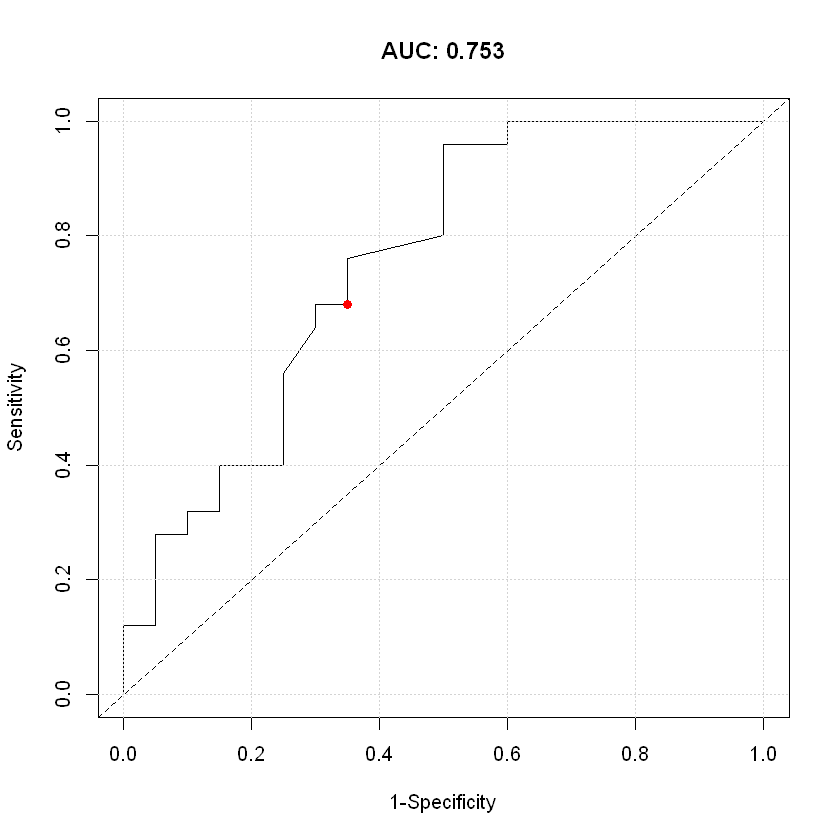

In [23]:
# AUC = Sum of area of trapezoids 
height = (SEN[-1]+SEN[-length(SEN)])/2  # 1/2(a+b)
width = -diff(1-SPE) #                  # h
auc = sum(height*width)

plot(1-SPE,SEN,type='l',xlab = '1-Specificity',ylab='Sensitivity',main= paste('AUC:', auc) )
abline(b = 1, a =0, lty=2)
grid()

paste('Max Accuracy =',round(max(ACC),3))
best_point = which(ACC == max(ACC))
paste('Max Sensitivity =',round(SEN[best_point],3))
paste('Max Specificity =',round(SPE[best_point],3))

points(x = 1-0.65, y = 0.68, col = 'red',pch = 19)